In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize to standard MNIST mean and std
    transforms.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.0), torch.tensor(0.0))),
    transforms.Lambda(lambda x: x.view(-1))
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 9912422/9912422 [00:01<00:00, 6613802.42it/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 28881/28881 [00:00<00:00, 1925937.55it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 1648877/1648877 [00:00<00:00, 8303925.81it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)>



100%|██████████| 4542/4542 [00:00<00:00, 758018.81it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



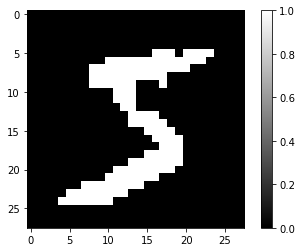

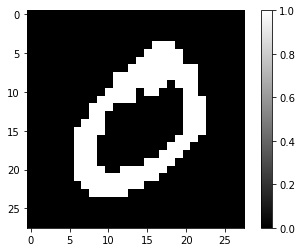

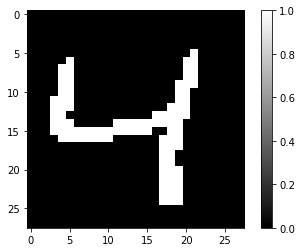

In [24]:
def display_image(num):
    for i in range(num):
        flattened_tensor = train_dataset[i][0]  # Replace with your actual data

        # Reshape to 28 x 28
        image_tensor = flattened_tensor.view(28, 28)  # or .reshape(28, 28)

        # Plot the image
        plt.imshow(image_tensor, cmap="gray")
        plt.colorbar()  # Optional: to show the color scale
        plt.show()

display_image(3)

In [66]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.softmax(x, dim=1)
        return x

model_fp32 = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_fp32.parameters(), lr=0.001, momentum=0.90)

In [65]:
num_epochs = 20

for epoch in range(num_epochs):
    model_fp32.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_fp32(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 1.692891001701355
Epoch 2/20, Loss: 1.6858046054840088
Epoch 3/20, Loss: 1.6241379976272583
Epoch 4/20, Loss: 1.6425410509109497
Epoch 5/20, Loss: 1.5989434719085693
Epoch 6/20, Loss: 1.7430771589279175
Epoch 7/20, Loss: 1.5453065633773804
Epoch 8/20, Loss: 1.6936087608337402
Epoch 9/20, Loss: 1.5765233039855957
Epoch 10/20, Loss: 1.5769398212432861
Epoch 11/20, Loss: 1.7183318138122559
Epoch 12/20, Loss: 1.6155794858932495
Epoch 13/20, Loss: 1.7283228635787964
Epoch 14/20, Loss: 1.5210025310516357
Epoch 15/20, Loss: 1.5532491207122803
Epoch 16/20, Loss: 1.5373444557189941
Epoch 17/20, Loss: 1.5543785095214844
Epoch 18/20, Loss: 1.5657790899276733
Epoch 19/20, Loss: 1.6888560056686401
Epoch 20/20, Loss: 1.5352859497070312


In [68]:
torch.save(model_fp32.state_dict(), "MNIST_6.pt")

model_fp32.eval()
with torch.no_grad():
    for data, target in test_loader:
        
        output = model_fp32(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the predicted class
        print(pred.squeeze(1), target)
        break



tensor([4, 4, 4, 6, 6, 4, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4,
        4, 4, 4, 6, 6, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 6, 4, 4]) tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [45]:
model_fp32.eval()  # Switch to evaluation mode before quantization
torch.backends.quantized.engine = 'qnnpack'
model_fp32.qconfig = torch.quantization.get_default_qconfig('qnnpack')  # 'fbgemm' for x86 architectures

# Prepare the model for quantization
torch.quantization.prepare(model_fp32, inplace=True)

# Calibrate the model on the training dataset (run through some data to collect quantization statistics)
with torch.no_grad():
    for data, _ in train_loader:
        model_fp32(data)

# Convert the model to quantized form
torch.quantization.convert(model_fp32, inplace=True)

SimpleNet(
  (fc1): QuantizedLinear(in_features=784, out_features=10, scale=0.08043649792671204, zero_point=140, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=10, out_features=10, scale=0.23036472499370575, zero_point=124, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=10, out_features=10, scale=0.5590093731880188, zero_point=121, qscheme=torch.per_tensor_affine)
)

In [46]:
model_fp32.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model_fp32(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the predicted class
        print(pred.squeeze(1), target)
        break

NotImplementedError: Could not run 'quantized::linear' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear' is only available for these backends: [MPS, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

MPS: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/mps/MPSFallback.mm:75 [backend fallback]
QuantizedCPU: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/native/quantized/cpu/qlinear.cpp:1137 [kernel]
BackendSelect: fallthrough registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:290 [backend fallback]
Named: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/torch/csrc/autograd/TraceTypeManual.cpp:296 [backend fallback]
AutocastCPU: fallthrough registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/autocast_mode.cpp:382 [backend fallback]
AutocastCUDA: fallthrough registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/autocast_mode.cpp:249 [backend fallback]
FuncTorchBatched: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:710 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400200181/work/aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]
